# ITSG Bug

In [1]:
import os
os.chdir('D:\open_source\pyshbundle')

import pyshbundle
from tqdm import trange
from datetime import datetime

from pyshbundle.new_io import read_jpl, read_csr, read_tn13, read_tn14, extract_C10_11_replcmnt_coeff, cklm2sc_new
from pyshbundle.new_io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, replace_zonal_coeff, find_date_in_replacemnt_file
from pyshbundle.new_io import read_itsg

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pyshbundle.reader_replacer_jpl
import pyshbundle.reader_replacer_csr
import pyshbundle.reader_replacer_itsg

from pyshbundle import gshs
from pyshbundle import clm2sc

In [3]:
def last_4chars(x):
        #print(x[-39:-32])
        return(x[-11:-4])

In [4]:
def clm2sc_new2(data_mat, lmax):
    sc_mat = np.zeros((lmax+1, 2*lmax + 2))
    dev_sc_mat = np.zeros((lmax+1, 2*lmax + 2))
    clm = data_mat[:, 2]
    slm = data_mat[:, 3]
    clm_std_dev = data_mat[:, 4]
    slm_std_dev = data_mat[:, 5]

    i = 0
    for index1 in range(0,lmax+1, 1):
        for index2 in range(0,index1+1, 1):
            
            sc_mat[index1, lmax-index2] = slm[i]
            sc_mat[index1, lmax+index2+1] = clm[i]

            dev_sc_mat[index1, lmax-index2] = slm_std_dev[i]
            dev_sc_mat[index1, lmax+index2+1] = clm_std_dev[i]

            i = i + 1
    
    sc_mat = np.delete(sc_mat, lmax, 1)
    dev_sc_mat = np.delete(dev_sc_mat, lmax, 1)
    return sc_mat, dev_sc_mat

In [5]:
tn14_path_itsg = 'D:\\open_source\\pyshbundle\pyshbundle\\data\\ITSG_TN_files\\TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_itsg = 'D:\\open_source\\pyshbundle\\pyshbundle\\data\\ITSG_TN_files\\TN-13_GEOC_CSR_RL06.1.txt'
itsg_folder = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input'
itsg_file = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input\\ITSG-Grace2018_n96_2011-05.gfc'

In [6]:
data_itsg_mat= np.ndarray((4753, 6))
header = read_itsg(itsg_file)[0]
data_itsg_mat = read_itsg(itsg_file)[1]
dates_itsg = read_itsg(itsg_file)[2]

In [8]:
type(dates_itsg)

str

In [7]:
from datetime import datetime, timedelta
def STR2DON(str_date, source='itsg'):
    if source == "itsg":
        #print("NOTE: ITSG only provides Year-Month, the Date Object Notation will assume it to be the first day of the corresponding month by default! \n")
        return datetime.strptime(str_date, "%Y-%m").date()
    elif source == "csr":
        return datetime.strptime(str_date, "%Y-%m-%d").date()
    elif source == "jpl":
        return datetime.strptime(str_date, "%Y-%m-%d").date()
    else:
        raise ValueError("Enter a valid data source (Processing Centre). Currently only supported for CSR, JPl and ITSG Processing Centers")

In [9]:
def dates_by_year(date_list: list, source='itsg'):
    if source == 'itsg':
        # accertain the type of list
        if type(date_list[0] == 'str'):
            for i in range(len(date_list)):
                date_list[i] = STR2DON(date_list[i], source='itsg')
        
        else:
            raise ValueError("dates should be a list of strings")
        
        list_of_years = []
        valid_months = set(range(1, 13))
        dates_by_year = {}
        # Group the dates by year
        for date in date_list:
            year = date.year
            if year not in dates_by_year:
                dates_by_year[year] = []
            dates_by_year[year].append(date)

        # Print the dates grouped by year
        return dates_by_year



        pass
    elif source == 'csr':
        pass
    elif source == 'jpl':
        pass
    pass

In [19]:
import copy
dates_list = copy.deepcopy(dates_start)

In [12]:
dates_by_year = dates_by_year(dates_list, source='itsg')

In [13]:
# pretty printing the header info
import pprint

pp = pprint.PrettyPrinter(indent=2, width=2, compact=True)
pp.pprint(dates_by_year)

{ 2002: [ datetime.date(2002, 4, 1),
          datetime.date(2002, 5, 1),
          datetime.date(2002, 8, 1),
          datetime.date(2002, 9, 1),
          datetime.date(2002, 10, 1),
          datetime.date(2002, 11, 1),
          datetime.date(2002, 12, 1)],
  2003: [ datetime.date(2003, 1, 1),
          datetime.date(2003, 2, 1),
          datetime.date(2003, 3, 1),
          datetime.date(2003, 4, 1),
          datetime.date(2003, 5, 1),
          datetime.date(2003, 7, 1),
          datetime.date(2003, 8, 1),
          datetime.date(2003, 9, 1),
          datetime.date(2003, 10, 1),
          datetime.date(2003, 11, 1),
          datetime.date(2003, 12, 1)],
  2004: [ datetime.date(2004, 1, 1),
          datetime.date(2004, 2, 1),
          datetime.date(2004, 3, 1),
          datetime.date(2004, 4, 1),
          datetime.date(2004, 5, 1),
          datetime.date(2004, 6, 1),
          datetime.date(2004, 7, 1),
          datetime.date(2004, 8, 1),
          datetime.date(2004, 

In [54]:
dates_by_year[list(dates_by_year.keys())[0]][0].month

4

In [25]:
def missing_months(yearwise_dates: dict):
    year_keys = list(yearwise_dates.keys())
    valid_months = set(range(1, 13))
    missing_data = {}

    for year in year_keys:
        
        dates_in_year = yearwise_dates[year]
        months_present = set(date.month for date in dates_in_year)
        missing_months = valid_months - months_present
        
        if len(missing_months) != 0:
            missing_data[year] = list(missing_months)
        else:
            missing_data[year] = 0
    

    return missing_data


In [26]:
missing_months = missing_months(yearwise_dates=dates_by_year)

In [30]:
missing_months[2002]

[1, 2, 3, 6, 7]

In [78]:
min(missing_months.keys())

2002

In [31]:
missing_months

{2002: [1, 2, 3, 6, 7],
 2003: [6],
 2004: 0,
 2005: 0,
 2006: 0,
 2007: 0,
 2008: 0,
 2009: 0,
 2010: 0,
 2011: [1, 6],
 2012: [10, 5],
 2013: [8, 9, 3],
 2014: [2, 12, 7],
 2015: [10, 11, 5, 6],
 2016: [9, 10, 4],
 2017: [2, 7, 8, 9, 10, 11, 12],
 2018: [1, 2, 3, 4, 5, 8, 9],
 2019: 0,
 2020: 0,
 2021: 0,
 2022: [12]}

In [ ]:
def timeseries_dataframe(data_dates: list, data: list, missing_months, column_header):
    
    
    

    
    pass

In [11]:
STR2DON(dates_itsg, source='itsg')

Note ITSG only provides Year-Month, the Date Object Notation will assume it to be the first day of the corresponding month by default! 



datetime.date(2011, 5, 1)

In [7]:
scmat_itsg, devscmat_itsg = clm2sc_new2(data_itsg_mat, lmax=96)

In [16]:
type(data_itsg_mat)

numpy.ndarray

In [11]:
from pyshbundle import sc2cs

In [14]:
a = sc2cs.sc2cs(clm2sc_new2(data_itsg_mat, 96)[0])

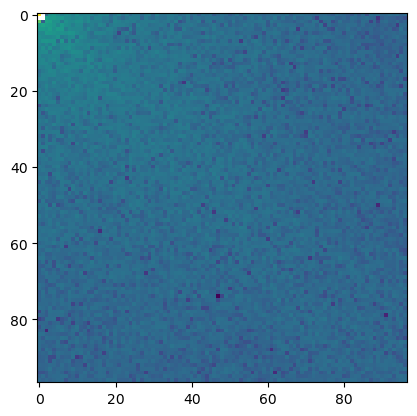

In [15]:
plt.imshow(np.ma.log10(np.absolute(a)))

In [8]:
type(scmat_itsg)

numpy.ndarray

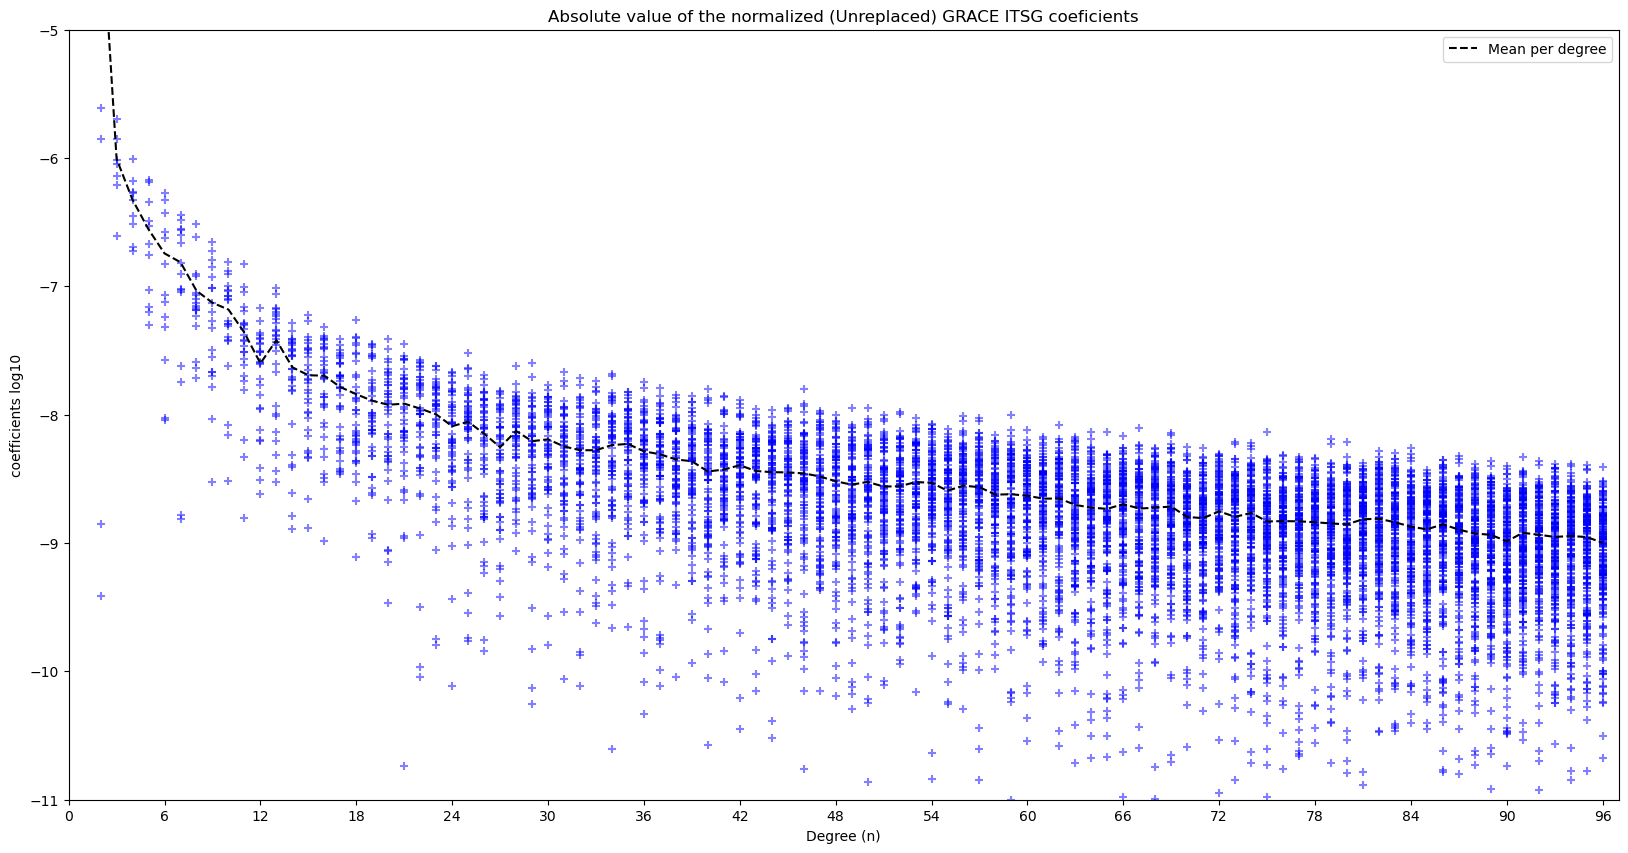

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))
degree_mean = []
for i in range(97):
    desparsed = np.absolute(de_sparse(scmat_itsg[i, :]))
    degree_mean.append(np.mean(desparsed))
    x = i * np.ones((len(desparsed)))

    ax.scatter(x, np.log10(desparsed), color='blue', marker='+', alpha=0.5)

ax.plot(range(97), np.log10(degree_mean), 'k', linestyle='--', label="Mean per degree")

x_vec = np.arange(0, 96+1, 6)

plt.ylim([-11, -5])
plt.xlim([0, 97])
plt.ylabel("coefficients log10")
plt.xlabel("Degree (n)")
plt.xticks(x_vec)
plt.title("Absolute value of the normalized (Unreplaced) GRACE ITSG coeficients")
plt.legend()
plt.show()

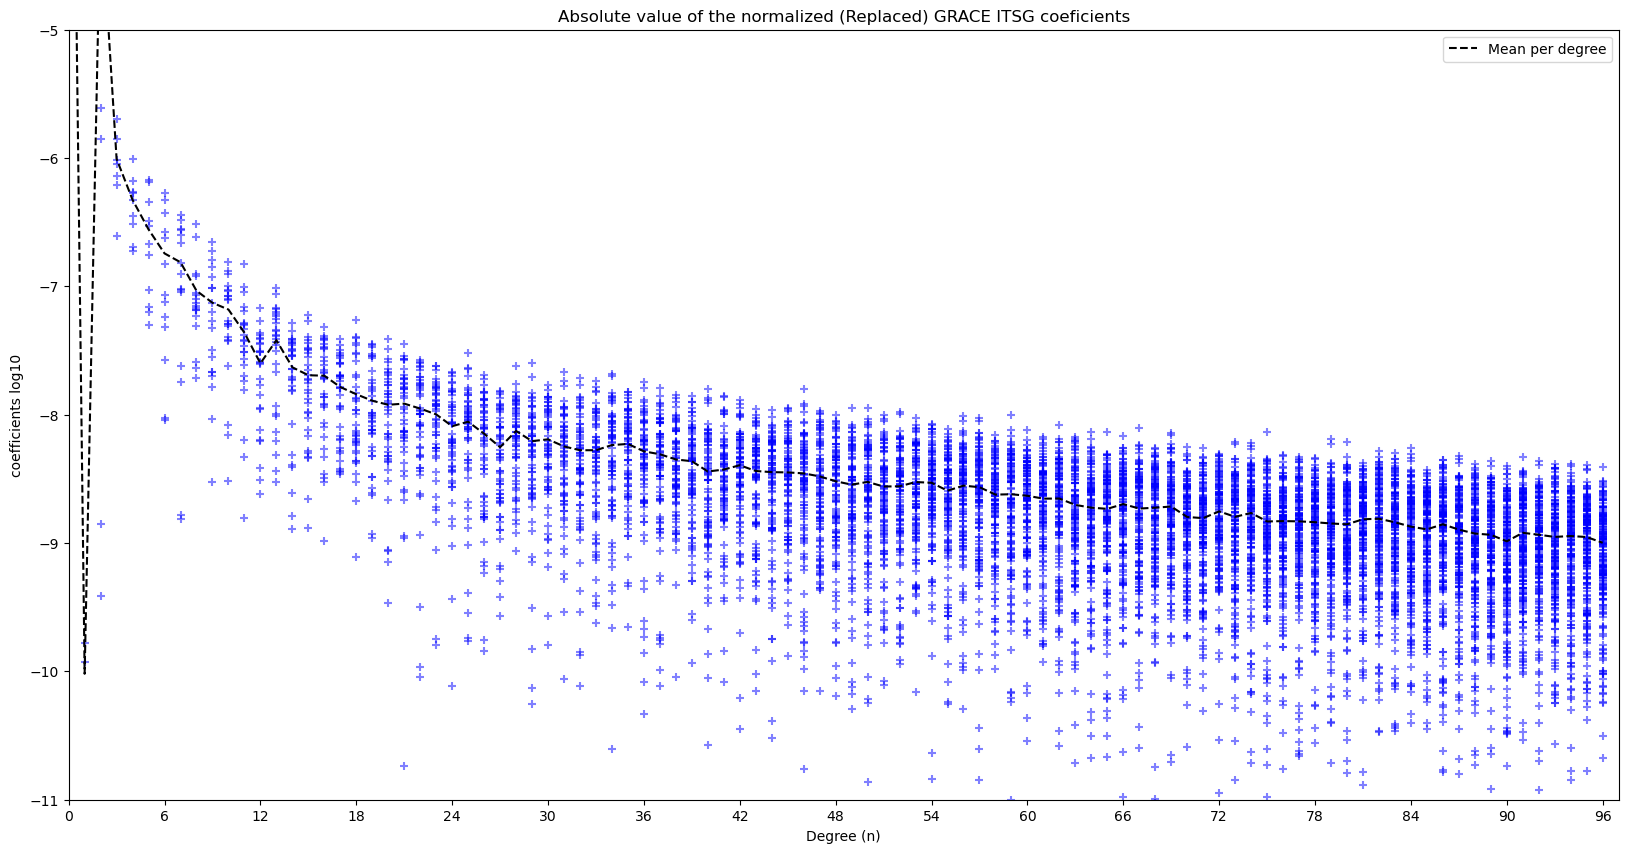

In [94]:

fig, ax = plt.subplots(figsize=(20, 10))
degree_mean = []
for i in range(97):
    desparsed = np.absolute(de_sparse(rep_sc[i, :]))
    degree_mean.append(np.mean(desparsed))
    x = i * np.ones((len(desparsed)))

    ax.scatter(x, np.log10(desparsed), color='blue', marker='+', alpha=0.5)

ax.plot(range(97), np.log10(degree_mean), 'k', linestyle='--', label="Mean per degree")

x_vec = np.arange(0, 96+1, 6)

plt.ylim([-11, -5])
plt.xlim([0, 97])
plt.ylabel("coefficients log10")
plt.xlabel("Degree (n)")
plt.xticks(x_vec)
plt.title("Absolute value of the normalized (Replaced) GRACE ITSG coeficients")
plt.legend()
plt.show()

In [25]:
import scipy.sparse as sps

a = sps.csr_matrix(scmat_itsg)


<1x193 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

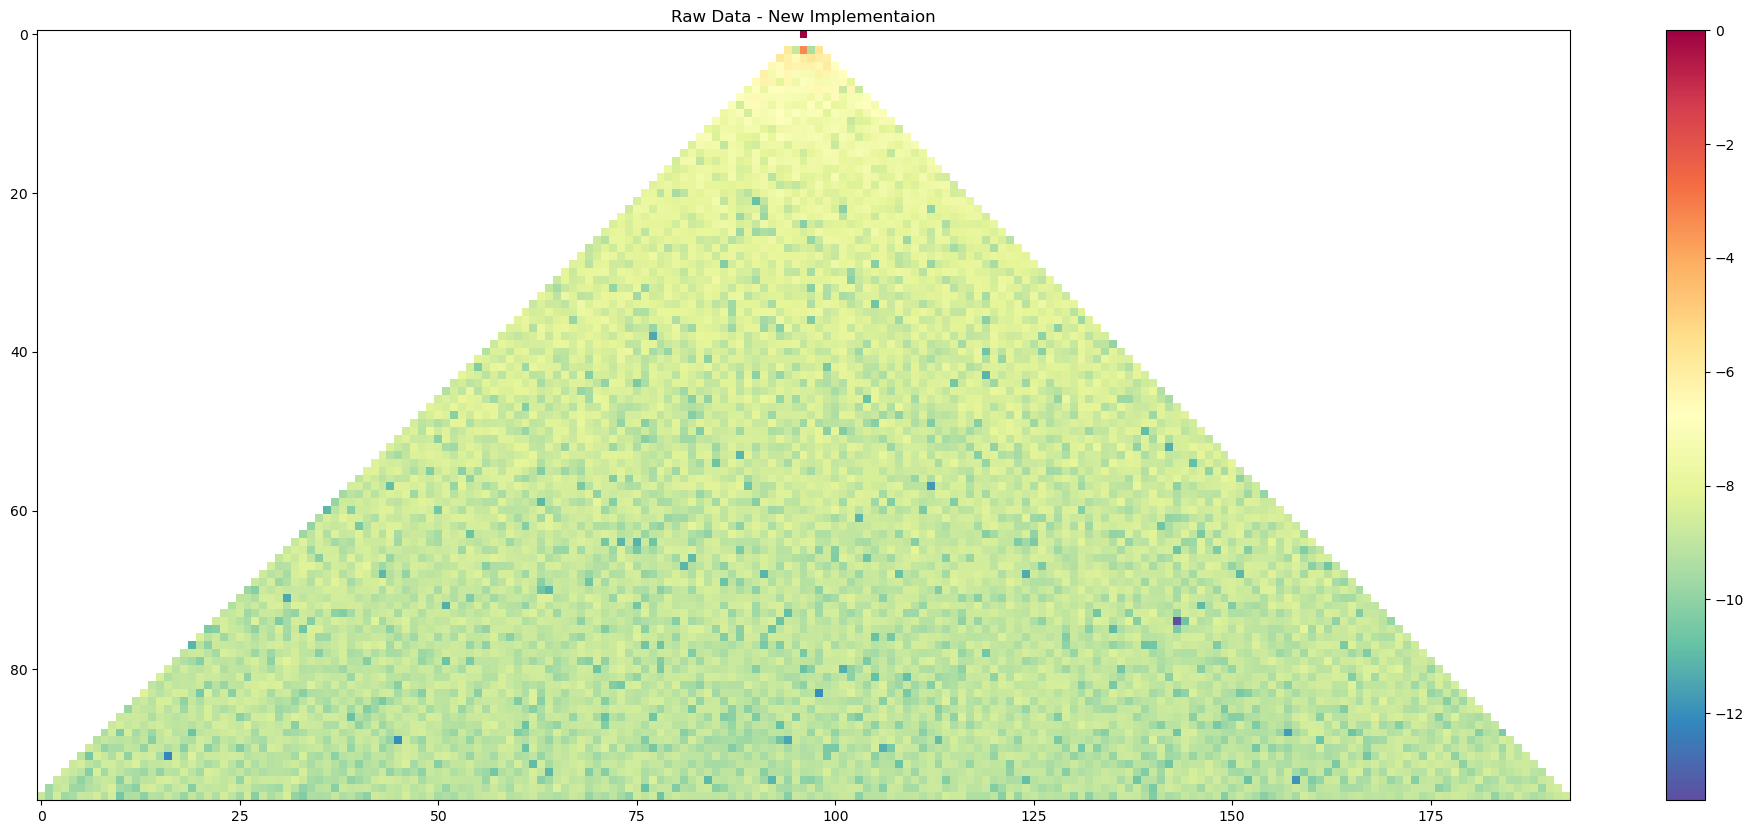

In [9]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(scmat_itsg)), cmap="Spectral_r")
plt.colorbar()
plt.title("Raw Data - New Implementaion")
plt.show()

In [96]:
scmat_itsg[0:5, 91:102]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.40040263e-06,  1.41435500e-09, -4.84169406e-04,
        -3.83640487e-10,  2.43934309e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.41444629e-06,
        -6.18947543e-07,  2.48295451e-07,  9.57283201e-07,
         2.03042116e-06,  9.04730984e-07,  7.21245241e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.08882178e-07, -2.00937310e-07,
         6.62581797e-07, -4.73563943e-07,  5.40000621e-07,
  

In [91]:
# Read replacemnt file
data_tn13_itsg = read_tn13(tn_13_path_itsg)
data_tn14_itsg = read_tn14(tn14_path_itsg)

In [98]:
data_tn13_itsg[0:5, :]

array([[ 1.00000000e+00,  0.00000000e+00,  5.21793863e-10,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00204050e+07,  2.00205010e+07],
       [ 1.00000000e+00,  1.00000000e+00,  2.86777277e-10,
        -6.80704629e-11,  4.52960000e-11,  5.07240000e-11,
         2.00204050e+07,  2.00205010e+07],
       [ 1.00000000e+00,  0.00000000e+00,  4.69850864e-10,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00205030e+07,  2.00205180e+07],
       [ 1.00000000e+00,  1.00000000e+00,  1.53669799e-10,
        -8.90896621e-11,  4.52960000e-11,  5.07240000e-11,
         2.00205030e+07,  2.00205180e+07],
       [ 1.00000000e+00,  0.00000000e+00,  4.10788808e-13,
         0.00000000e+00,  4.45850000e-11,  0.00000000e+00,
         2.00208010e+07,  2.00209010e+07]])

In [99]:
data_tn14_itsg[0:5, :]

array([[-4.84169326e-04,  1.58900000e-11,             nan,
                    nan,  1.31020000e-10,             nan,
         5.23680000e+04,  5.23950000e+04],
       [-4.84169336e-04,  1.51000000e-11,             nan,
                    nan,  1.21090000e-10,             nan,
         5.23960000e+04,  5.24130000e+04],
       [-4.84169473e-04,  1.43600000e-11,             nan,
                    nan, -1.52000000e-11,             nan,
         5.24870000e+04,  5.25180000e+04],
       [-4.84169476e-04,  1.59400000e-11,             nan,
                    nan, -1.87100000e-11,             nan,
         5.25180000e+04,  5.25480000e+04],
       [-4.84169451e-04,  1.52400000e-11,             nan,
                    nan,  6.72000000e-12,             nan,
         5.25480000e+04,  5.25790000e+04]])

# Let's Observe the Replacemnt Procedure

In [92]:
replaced_data_mat = replace_zonal_coeff(data_itsg_mat, 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg, epoch_end=None)

Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
[1.00000000e+00 0.00000000e+00 1.92070086e-12 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.19237304e-10 -1.66149501e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01


In [93]:
rep_sc, rep_dev = clm2sc_new2(replaced_data_mat, lmax=96)

In [102]:
rep_sc[0:5, 91:102]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.66149501e-10,  1.92070086e-12,
         1.19237304e-10,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.40040263e-06,  1.41435500e-09, -4.84169467e-04,
        -3.83640487e-10,  2.43934309e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.41444629e-06,
        -6.18947543e-07,  2.48295451e-07,  9.57283201e-07,
         2.03042116e-06,  9.04730984e-07,  7.21245241e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.08882178e-07, -2.00937310e-07,
         6.62581797e-07, -4.73563943e-07,  5.40000621e-07,
  

In [103]:
epoch_begin = datetime.strptime(dates_itsg, '%Y-%m').date()
tn_13_idx = find_date_in_replacemnt_file(data_tn13_itsg, "tn-13", "itsg", epoch_begin)
print(f"The TN-13 indices found to match : {tn_13_idx}")

Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
The TN-13 indices found to match : [210, 211]


In [104]:
# This is the TN-14 Replacement file data from the matrix

epoch_begin = datetime.strptime(dates_itsg, '%Y-%m').date()
tn_14_idx = find_date_in_replacemnt_file(data_tn14_itsg, "tn-14", "itsg", epoch_begin)
print(f"The TN-14 indices found to match : {tn_14_idx}")

Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01
The TN-14 indices found to match : [105]


## Vivek's Approach

In [10]:
itsg_clm, dates_start, no_of_files = pyshbundle.reader_replacer_itsg.reader_replacer_itsg(itsg_folder, tn14_path_itsg, tn_13_path_itsg)

ITSG
Reading into clm format complete!
Number of files read: 214
Starting replacement
found: 37
Data date - 2002-04-01 00:00:00, replacemebt date (tn-14) = 2002-04-04 00:00:00
Data date - 2002-05-01 00:00:00, replacemebt date (tn-14) = 2002-05-02 00:00:00
Data date - 2002-08-01 00:00:00, replacemebt date (tn-14) = 2002-08-01 00:00:00
Data date - 2002-09-01 00:00:00, replacemebt date (tn-14) = 2002-09-01 00:00:00
Data date - 2002-10-01 00:00:00, replacemebt date (tn-14) = 2002-10-01 00:00:00
Data date - 2002-11-01 00:00:00, replacemebt date (tn-14) = 2002-11-01 00:00:00
Data date - 2002-12-01 00:00:00, replacemebt date (tn-14) = 2002-12-01 00:00:00
Data date - 2003-01-01 00:00:00, replacemebt date (tn-14) = 2003-01-01 00:00:00
Data date - 2003-02-01 00:00:00, replacemebt date (tn-14) = 2003-02-01 00:00:00
Data date - 2003-03-01 00:00:00, replacemebt date (tn-14) = 2003-03-01 00:00:00
Data date - 2003-04-01 00:00:00, replacemebt date (tn-14) = 2003-04-01 00:00:00
Data date - 2003-05-01 0

In [29]:
itsg_sc, itsg_dev_sc = pyshbundle.clm2sc.clm2sc(itsg_clm)

Conversion into clm format complete


In [107]:
itsg_sc[105, 0:5, 91:102]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.66149501e-10,  1.92070086e-12,
         1.19237304e-10,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.40040263e-06,  1.41435500e-09, -4.84169467e-04,
        -3.83640487e-10,  2.43934309e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.41444629e-06,
        -6.18947543e-07,  2.48295451e-07,  9.57283201e-07,
         2.03042116e-06,  9.04730984e-07,  7.21245241e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.08882178e-07, -2.00937310e-07,
         6.62581797e-07, -4.73563943e-07,  5.40000621e-07,
  

In [111]:
np.sum(abs(itsg_sc[105, :] - rep_sc))

0.0

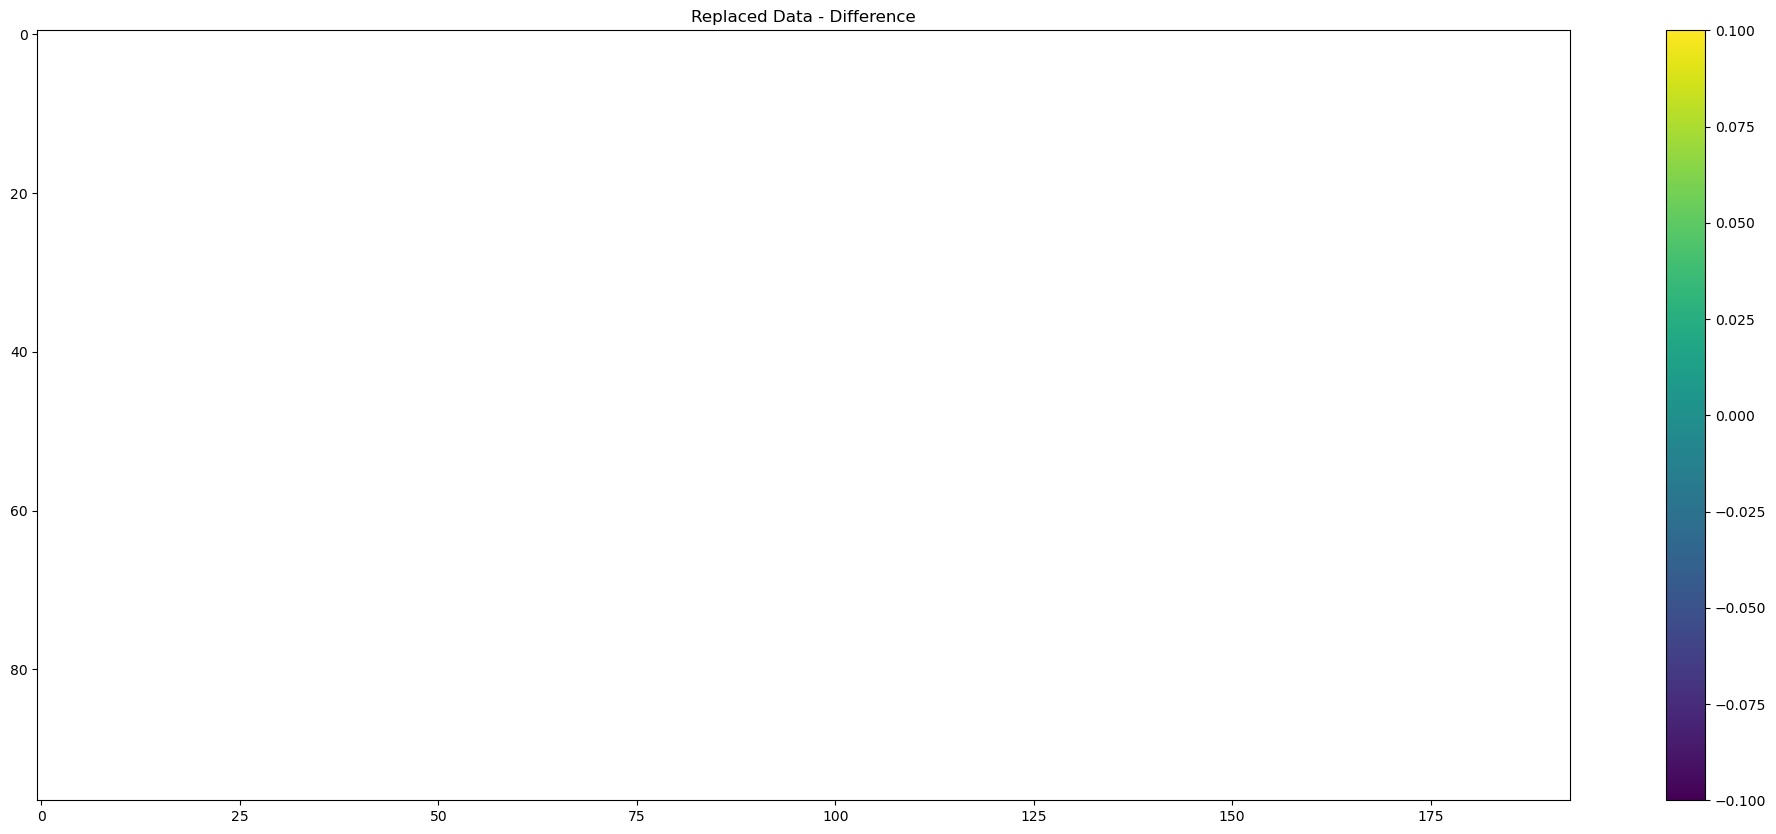

In [110]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs((itsg_sc[105, :] - rep_sc))), )
plt.colorbar()
plt.title("Replaced Data - Difference")
plt.show()

In [9]:
# load all the itsg files
files = os.listdir(itsg_folder)
files = sorted(files, key = last_4chars)

data_itsg_mat = np.ndarray((len(files), 4753, 6))
dates_itsg = []
for i in trange(len(files)):
    file_path = itsg_folder + '\\' + files[i]
    header = read_itsg(file_path)[0]
    data_itsg_mat[i, :, :] = read_itsg(file_path)[1]
    dates_itsg.append(read_itsg(file_path)[2])

100%|██████████| 214/214 [00:26<00:00,  8.04it/s]


In [13]:
header

{}

In [12]:
type(read_itsg(file_path)[2])

str

In [133]:
#replace_zonal_coeff(data_mat, data_tn13, data_tn14, epoch_begin, epoch_end)
# Replace zonal coeff
replaced_data_mat_itsg = np.ndarray((len(files), 4753, 6))

unreplaced_idx = set()
for i in trange(len(files)):
    try:
        replaced_data_mat_itsg[i, :, :] = replace_zonal_coeff(data_itsg_mat[i, :, :], 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg[i], epoch_end=None)
        print("\n")
    except IndexError:
        print(f"Replacement data for File Index {i} - {dates_itsg[i]} could not be found.... procedding to next file")
        unreplaced_idx.add(i)

unreplaced_idx = list(unreplaced_idx)

  2%|▏         | 5/214 [00:00<00:04, 43.66it/s]

Data Date - 2002-04-01, replacemnt date(tn-13) = 2002-04-05
Data Date - 2002-04-01, replacemnt date(tn-13) = 2002-04-05
[1.00000000e+00 0.00000000e+00 5.21793863e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.86777277e-10 -6.80704629e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2002-04-01, replacemnt date (tn-14)_ = 2002-04-04
Data Date - 2002-04-01, replacemnt date (tn-14)_ = 2002-04-04


Data Date - 2002-05-01, replacemnt date(tn-13) = 2002-05-03
Data Date - 2002-05-01, replacemnt date(tn-13) = 2002-05-03
[1.00000000e+00 0.00000000e+00 4.69850864e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.53669799e-10 -8.90896621e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2002-05-01, replacemnt date (tn-14)_ = 2002-05-02
Data Date - 2002-05-01, replacemnt date (tn-14)_ = 2002-05-02


Data Date - 2002-08-01, replacemnt date(tn-13) = 2002-08-01
Data Date - 2002-08-01, replacemnt date(tn-13) = 2002-08-01
[1.0

 10%|▉         | 21/214 [00:00<00:02, 68.78it/s]



Data Date - 2003-07-01, replacemnt date(tn-13) = 2003-07-01
Data Date - 2003-07-01, replacemnt date(tn-13) = 2003-07-01
[1.00000000e+00 0.00000000e+00 9.70078027e-12 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  4.57600314e-11 -3.88527543e-13
  4.52960000e-11  5.07240000e-11]
Data Date - 2003-07-01, replacemnt date (tn-14)_ = 2003-07-01
Data Date - 2003-07-01, replacemnt date (tn-14)_ = 2003-07-01


Data Date - 2003-08-01, replacemnt date(tn-13) = 2003-08-01
Data Date - 2003-08-01, replacemnt date(tn-13) = 2003-08-01
[ 1.00000000e+00  0.00000000e+00 -8.48334144e-11  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [1.00000000e+00 1.00000000e+00 8.99940877e-12 1.56049408e-10
 4.52960000e-11 5.07240000e-11]
Data Date - 2003-08-01, replacemnt date (tn-14)_ = 2003-08-01
Data Date - 2003-08-01, replacemnt date (tn-14)_ = 2003-08-01


Data Date - 2003-09-01, replacemnt date(tn-13) = 2003-09-01
Data Date - 2003-09-01, replacemnt date(tn-13) = 2003-09-01
[ 

 18%|█▊        | 38/214 [00:00<00:02, 70.80it/s]



Data Date - 2004-11-01, replacemnt date(tn-13) = 2004-11-01
Data Date - 2004-11-01, replacemnt date(tn-13) = 2004-11-01
[1.00000000e+00 0.00000000e+00 1.00374114e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -7.59082948e-11  1.01255599e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2004-11-01, replacemnt date (tn-14)_ = 2004-11-01
Data Date - 2004-11-01, replacemnt date (tn-14)_ = 2004-11-01


Data Date - 2004-12-01, replacemnt date(tn-13) = 2004-12-01
Data Date - 2004-12-01, replacemnt date(tn-13) = 2004-12-01
[1.00000000e+00 0.00000000e+00 2.45033395e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.0000000e+00  1.0000000e+00 -3.7013782e-11  6.3545522e-11
  4.5296000e-11  5.0724000e-11]
Data Date - 2004-12-01, replacemnt date (tn-14)_ = 2004-12-01
Data Date - 2004-12-01, replacemnt date (tn-14)_ = 2004-12-01


Data Date - 2005-01-01, replacemnt date(tn-13) = 2005-01-01
Data Date - 2005-01-01, replacemnt date(tn-13) = 2005-01-01
[1.00000

 25%|██▌       | 54/214 [00:00<00:02, 70.48it/s]



Data Date - 2006-03-01, replacemnt date(tn-13) = 2006-03-01
Data Date - 2006-03-01, replacemnt date(tn-13) = 2006-03-01
[1.00000000e+00 0.00000000e+00 3.18940861e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.08871545e-10 -4.67010531e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2006-03-01, replacemnt date (tn-14)_ = 2006-03-01
Data Date - 2006-03-01, replacemnt date (tn-14)_ = 2006-03-01


Data Date - 2006-04-01, replacemnt date(tn-13) = 2006-04-01
Data Date - 2006-04-01, replacemnt date(tn-13) = 2006-04-01
[1.00000000e+00 0.00000000e+00 3.34681193e-10 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.09683992e-10 -1.50030455e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2006-04-01, replacemnt date (tn-14)_ = 2006-04-01
Data Date - 2006-04-01, replacemnt date (tn-14)_ = 2006-04-01


Data Date - 2006-05-01, replacemnt date(tn-13) = 2006-05-01
Data Date - 2006-05-01, replacemnt date(tn-13) = 2006-05-01
[1

 34%|███▎      | 72/214 [00:01<00:01, 75.92it/s]



Data Date - 2007-07-01, replacemnt date(tn-13) = 2007-07-01
Data Date - 2007-07-01, replacemnt date(tn-13) = 2007-07-01
[ 1.00000000e+00  0.00000000e+00 -9.68890057e-11  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -4.98725785e-11  5.65331008e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2007-07-01, replacemnt date (tn-14)_ = 2007-07-01
Data Date - 2007-07-01, replacemnt date (tn-14)_ = 2007-07-01


Data Date - 2007-08-01, replacemnt date(tn-13) = 2007-08-01
Data Date - 2007-08-01, replacemnt date(tn-13) = 2007-08-01
[ 1.00000000e+00  0.00000000e+00 -1.51915372e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.55887540e-11  2.01743114e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2007-08-01, replacemnt date (tn-14)_ = 2007-08-01
Data Date - 2007-08-01, replacemnt date (tn-14)_ = 2007-08-01


Data Date - 2007-09-01, replacemnt date(tn-13) = 2007-09-01
Data Date - 2007-09-01, replacemnt date(tn-13) = 2

 42%|████▏     | 89/214 [00:01<00:01, 77.78it/s]



Data Date - 2008-11-01, replacemnt date(tn-13) = 2008-11-01
Data Date - 2008-11-01, replacemnt date(tn-13) = 2008-11-01
[ 1.00000000e+00  0.00000000e+00 -1.61356916e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.54437552e-10  9.09207156e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2008-11-01, replacemnt date (tn-14)_ = 2008-11-01
Data Date - 2008-11-01, replacemnt date (tn-14)_ = 2008-11-01


Data Date - 2008-12-01, replacemnt date(tn-13) = 2008-12-01
Data Date - 2008-12-01, replacemnt date(tn-13) = 2008-12-01
[ 1.00000000e+00  0.00000000e+00 -3.00018104e-11  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.71401381e-11  3.65689942e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2008-12-01, replacemnt date (tn-14)_ = 2008-12-01
Data Date - 2008-12-01, replacemnt date (tn-14)_ = 2008-12-01


Data Date - 2009-01-01, replacemnt date(tn-13) = 2009-01-01
Data Date - 2009-01-01, replacemnt date(tn-13) = 2

 49%|████▉     | 105/214 [00:01<00:01, 75.86it/s]



Data Date - 2010-08-01, replacemnt date(tn-13) = 2010-08-01
Data Date - 2010-08-01, replacemnt date(tn-13) = 2010-08-01
[ 1.00000000e+00  0.00000000e+00 -3.62978637e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.05520599e-10  7.46887789e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2010-08-01, replacemnt date (tn-14)_ = 2010-08-01
Data Date - 2010-08-01, replacemnt date (tn-14)_ = 2010-08-01


Data Date - 2010-09-01, replacemnt date(tn-13) = 2010-09-01
Data Date - 2010-09-01, replacemnt date(tn-13) = 2010-09-01
[ 1.00000000e+00  0.00000000e+00 -3.83720929e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.05244704e-10  2.29641694e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2010-09-01, replacemnt date (tn-14)_ = 2010-09-01
Data Date - 2010-09-01, replacemnt date (tn-14)_ = 2010-09-01


Data Date - 2010-10-01, replacemnt date(tn-13) = 2010-10-01
Data Date - 2010-10-01, replacemnt date(tn-13) = 2

 57%|█████▋    | 121/214 [00:01<00:01, 73.16it/s]



Data Date - 2012-01-01, replacemnt date(tn-13) = 2011-12-13
Data Date - 2012-01-01, replacemnt date(tn-13) = 2011-12-13
Data Date - 2012-01-01, replacemnt date(tn-13) = 2012-01-01
Data Date - 2012-01-01, replacemnt date(tn-13) = 2012-01-01
[ 1.00000000e+00  0.00000000e+00 -2.42906929e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -5.29055601e-11  7.24993593e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 2011-12-17
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 2012-01-01
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 2011-12-17
Data Date - 2012-01-01, replacemnt date (tn-14)_ = 2012-01-01


Data Date - 2012-02-01, replacemnt date(tn-13) = 2012-02-01
Data Date - 2012-02-01, replacemnt date(tn-13) = 2012-02-01
[ 1.00000000e+00  0.00000000e+00 -2.06339648e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -5.18572366e-11 -3.27509974e-11
  4.52960000e-11  5.072400

 64%|██████▍   | 137/214 [00:01<00:01, 70.68it/s]



Data Date - 2013-10-01, replacemnt date(tn-13) = 2013-10-01
Data Date - 2013-10-01, replacemnt date(tn-13) = 2013-10-01
[ 1.00000000e+00  0.00000000e+00 -4.90844092e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.96637275e-10  2.19057687e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2013-10-01, replacemnt date (tn-14)_ = 2013-10-01
Data Date - 2013-10-01, replacemnt date (tn-14)_ = 2013-10-01


Data Date - 2013-11-01, replacemnt date(tn-13) = 2013-11-01
Data Date - 2013-11-01, replacemnt date(tn-13) = 2013-11-01
[ 1.00000000e+00  0.00000000e+00 -4.07250206e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.09803473e-10  1.97653753e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2013-11-01, replacemnt date (tn-14)_ = 2013-11-01
Data Date - 2013-11-01, replacemnt date (tn-14)_ = 2013-11-01


Data Date - 2013-12-01, replacemnt date(tn-13) = 2013-12-01
Data Date - 2013-12-01, replacemnt date(tn-13) = 2

 71%|███████▏  | 153/214 [00:02<00:00, 66.73it/s]



Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-01-13
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-01-13
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-02-01
Data Date - 2015-02-01, replacemnt date(tn-13) = 2015-02-01
[ 1.00000000e+00  0.00000000e+00 -3.30739962e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.73299696e-11  9.92501049e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 2015-01-13
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 2015-02-01
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 2015-01-13
Data Date - 2015-02-01, replacemnt date (tn-14)_ = 2015-02-01


Data Date - 2015-03-01, replacemnt date(tn-13) = 2015-03-01
Data Date - 2015-03-01, replacemnt date(tn-13) = 2015-03-01
[ 1.0000000e+00  0.0000000e+00 -2.0157551e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [ 1.00000000e+00  1.00000000e+00 -3.31359882e-11 -4.28150220e-11
  4.52960000e-11  5.07240000e-11

 79%|███████▉  | 169/214 [00:02<00:00, 70.38it/s]



Data Date - 2017-03-01, replacemnt date(tn-13) = 2017-03-17
Data Date - 2017-03-01, replacemnt date(tn-13) = 2017-03-17
[ 1.00000000e+00  0.00000000e+00 -1.71548858e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  2.36751483e-11 -3.87390576e-12
  4.52960000e-11  5.07240000e-11]
Data Date - 2017-03-01, replacemnt date (tn-14)_ = 2017-03-17
Data Date - 2017-03-01, replacemnt date (tn-14)_ = 2017-03-17


Data Date - 2017-04-01, replacemnt date(tn-13) = 2017-03-17
Data Date - 2017-04-01, replacemnt date(tn-13) = 2017-03-17
Data Date - 2017-04-01, replacemnt date(tn-13) = 2017-04-10
Data Date - 2017-04-01, replacemnt date(tn-13) = 2017-04-10
[ 1.0000000e+00  0.0000000e+00 -3.2831994e-10  0.0000000e+00
  4.4585000e-11  0.0000000e+00] [ 1.00000000e+00  1.00000000e+00 -6.76824569e-11 -6.32003039e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2017-04-01, replacemnt date (tn-14)_ = 2017-03-17
Data Date - 2017-04-01, replacemnt date (tn-14)_ = 2017-04-1

 86%|████████▋ | 185/214 [00:02<00:00, 71.45it/s]



Data Date - 2019-09-01, replacemnt date(tn-13) = 2019-09-01
Data Date - 2019-09-01, replacemnt date(tn-13) = 2019-09-01
[ 1.00000000e+00  0.00000000e+00 -8.11715029e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.63668438e-10  1.40662605e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2019-09-01, replacemnt date (tn-14)_ = 2019-09-01
Data Date - 2019-09-01, replacemnt date (tn-14)_ = 2019-09-01


Data Date - 2019-10-01, replacemnt date(tn-13) = 2019-10-01
Data Date - 2019-10-01, replacemnt date(tn-13) = 2019-10-01
[ 1.00000000e+00  0.00000000e+00 -7.59338771e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -2.42598479e-10  2.12460174e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2019-10-01, replacemnt date (tn-14)_ = 2019-10-01
Data Date - 2019-10-01, replacemnt date (tn-14)_ = 2019-10-01


Data Date - 2019-11-01, replacemnt date(tn-13) = 2019-11-01
Data Date - 2019-11-01, replacemnt date(tn-13) = 2

 94%|█████████▍| 201/214 [00:02<00:00, 67.77it/s]



Data Date - 2020-12-01, replacemnt date(tn-13) = 2020-12-01
Data Date - 2020-12-01, replacemnt date(tn-13) = 2020-12-01
[ 1.00000000e+00  0.00000000e+00 -5.68793295e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -1.80358603e-10  2.38154881e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2020-12-01, replacemnt date (tn-14)_ = 2020-12-01
Data Date - 2020-12-01, replacemnt date (tn-14)_ = 2020-12-01


Data Date - 2021-01-01, replacemnt date(tn-13) = 2021-01-01
Data Date - 2021-01-01, replacemnt date(tn-13) = 2021-01-01
[ 1.00000000e+00  0.00000000e+00 -4.90757516e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00 -9.26908363e-11  1.27805430e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2021-01-01, replacemnt date (tn-14)_ = 2021-01-01
Data Date - 2021-01-01, replacemnt date (tn-14)_ = 2021-01-01


Data Date - 2021-02-01, replacemnt date(tn-13) = 2021-02-01
Data Date - 2021-02-01, replacemnt date(tn-13) = 2

100%|██████████| 214/214 [00:03<00:00, 70.98it/s]



Data Date - 2022-03-01, replacemnt date(tn-13) = 2022-03-01
Data Date - 2022-03-01, replacemnt date(tn-13) = 2022-03-01
[ 1.00000000e+00  0.00000000e+00 -4.53193643e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [1.00000000e+00 1.00000000e+00 5.11079704e-12 4.02960086e-11
 4.52960000e-11 5.07240000e-11]
Data Date - 2022-03-01, replacemnt date (tn-14)_ = 2022-03-01
Data Date - 2022-03-01, replacemnt date (tn-14)_ = 2022-03-01


Data Date - 2022-04-01, replacemnt date(tn-13) = 2022-04-01
Data Date - 2022-04-01, replacemnt date(tn-13) = 2022-04-01
[ 1.00000000e+00  0.00000000e+00 -4.62126538e-10  0.00000000e+00
  4.45850000e-11  0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  7.07695279e-11 -8.24673632e-11
  4.52960000e-11  5.07240000e-11]
Data Date - 2022-04-01, replacemnt date (tn-14)_ = 2022-04-01
Data Date - 2022-04-01, replacemnt date (tn-14)_ = 2022-04-01


Data Date - 2022-05-01, replacemnt date(tn-13) = 2022-05-01
Data Date - 2022-05-01, replacemnt date(tn-13) = 2022-05

In [134]:
scmat_deck_itsg = np.ndarray((len(files), 97, 193))
devscmat_deck_itsg = np.ndarray((len(files), 97, 193))

for i in trange(196):
    if i not in unreplaced_idx:
        scmat_deck_itsg[i, :, :], devscmat_deck_itsg[i, :, :] = clm2sc_new2(replaced_data_mat_itsg[i, :, :], lmax=96)

100%|██████████| 196/196 [00:00<00:00, 225.34it/s]


In [138]:
scmat_diff_itsg = np.ndarray((len(files), 97, 193))
devscmat_diff_itsg = np.ndarray((len(files), 97, 193))

for i in range(193):
    scmat_diff_itsg[i, :, :] = scmat_deck_itsg[i, :, :] - itsg_sc[i, :, :]
    devscmat_diff_itsg[i, :, :] = devscmat_deck_itsg[i, :, :] - itsg_dev_sc[i, :, :]

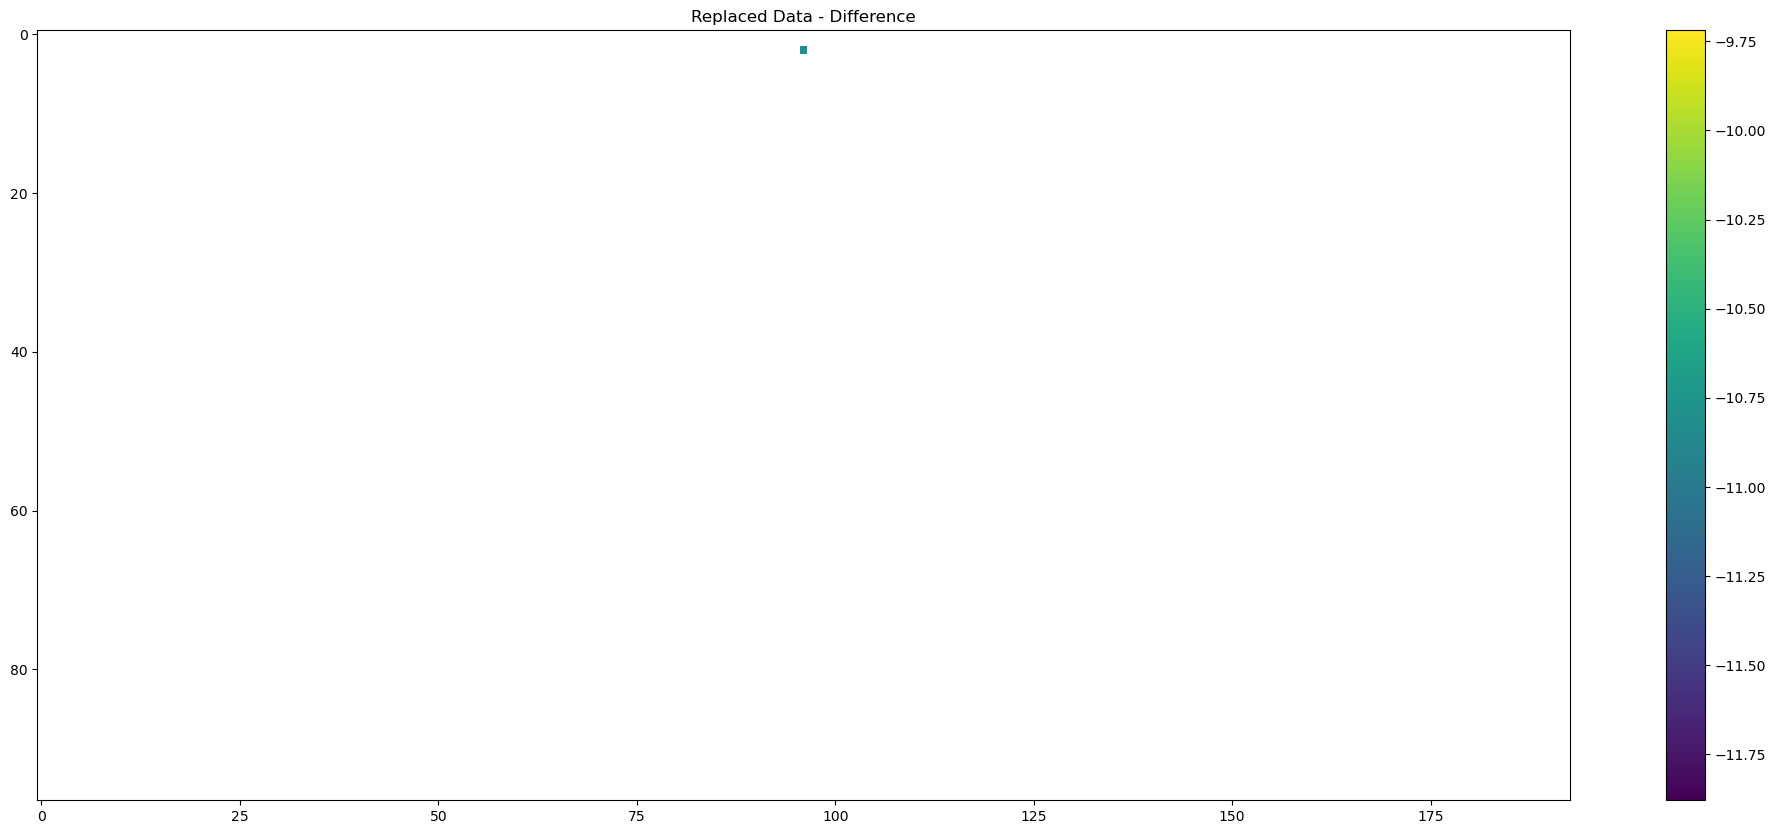

In [140]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_diff_itsg[0, :, :])))
plt.colorbar()
plt.title("Replaced Data - Difference")
plt.show()